# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




DistilBERT’s 66 million parameters make it 40% smaller and 60% faster than BERT-base, while retaining more than 95% of BERT’s performance

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 5.5 MB 29.0 MB/s 
     |████████████████████████████████| 1.3 MB 37.0 MB/s 
     |████████████████████████████████| 182 kB 50.9 MB/s 
     |████████████████████████████████| 7.6 MB 41.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=467a153a2d724074fc9aae863eed028fc96179a9f2ac2f4c826258140352cbe0
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
!pip install spacy -q
!python -m spacy download en_core_web_sm

2022-11-26 02:59:53.572789: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls "//content/drive/My Drive/AI_assignment/amazon_food_review/"

Mounted at /content/drive
cv-embeddings.pkl  seg_weights.best.hdf5  train-embeddings.pkl
Reviews.csv	   test-embeddings.pkl


In [6]:
display = pd.read_csv("//content/drive/My Drive/AI_assignment/amazon_food_review/Reviews.csv")

In [7]:
print(display.shape)
display.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## We only use 1000 reviews instead of all, to shorten training time

In [8]:
selected_data = display[:1000]
filtered_data = selected_data[selected_data['Score'] != 3 ]

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (925, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

In [9]:
v = filtered_data.UserId.value_counts()
filtered_data[filtered_data.UserId.isin(v.index[v.gt(1)])]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,1,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,1,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
238,239,B001EO5ZME,AF72GTWZGAC61,Pinkhat,0,0,1,1330387200,Great tasting green tea and such a great deal.,A very delicate green tea with a smooth light ...
240,241,B001EO5ZMY,AF72GTWZGAC61,Pinkhat,3,3,1,1330732800,Excellent loose tea.,"If you like the Ceylon tea variety, you will c..."
308,309,B003YDP5PA,AAZ084UMH8VZ2,"D. L. Brown ""A Knower Of Good Things""",3,3,1,1299196800,One of my Favoritte foods,Try this you might like it. I did and I am qui...
369,370,B002O3VHXU,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",1,1,1,1282176000,Very Smooth Coffee - Highly Recommended,"Green Mountain ""Nantucket Blend"" K-Cups make a..."
422,423,B000G6RYNE,A2NO1TXXS9T0EE,BruteNStones,0,0,1,1335398400,Hard,"Great if you are cutting back on fat, they do ..."
423,424,B000G6RYNE,A1IRN1M05TPOVT,"Sharon M. Helfand ""Scrapper""",0,0,1,1334620800,Kettle potato chips: Fully loaded baked potato,I have never met a Kettle brand chip I did not...
425,426,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,1,1334016000,glad to find them in 1 oz size,"I buy mostly for vending, so the size of the b..."
426,427,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,1,1334016000,"pretty good, could be better",Glad to find these in a one ounce size but the...


## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
filtered_data[filtered_data['UserId'] == 'AR5J8UI46CURR' ]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
filtered_data['Time'] = filtered_data['Time'].astype(int)

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(923, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.78378378378379

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Sort the final df based on time column inorder to use TimeSeriesSplit
final =final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

## [2.2] Balanced or Imbalanced

In [17]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(923, 10)


1    778
0    145
Name: Score, dtype: int64

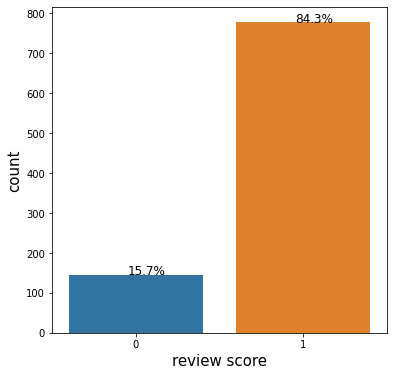

In [18]:
#https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

plt.figure(figsize=(6,6))
ax= sns.countplot(final.Score)
plt.xlabel('review score', size=15);
plt.ylabel('count', size=15);
without_hue(ax, final.Score)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [19]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[300]
print(sent_1000)
print("="*50)

I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!
I love strong, full bodied quality tea and typically drink assam, irish breakfast or early grey tea, but as the other reviewer noted the price per pound can be discouraging. So I have been searching for a quality full bo

In [20]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
print(sent_0)

I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [21]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.Thank you for the personal, incredible service!
I love strong, full bodied quality tea and typically drink assam, irish breakfast or early grey tea, but as the other reviewer noted the price per pound can be discouraging. So I have been searching for a quality full bodied tea that wasn't bitter at a mor

In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent_1000 = decontracted(sent_1000)
print(sent_1000)
print("="*50)

I love strong, full bodied quality tea and typically drink assam, irish breakfast or early grey tea, but as the other reviewer noted the price per pound can be discouraging. So I have been searching for a quality full bodied tea that was not bitter at a more palatable price point, and this certainly fits the bill. And unlike some other teas where they tend to be better in one form or another, i.e. iced vs. hot, this tea is excellent in both forms. I would certainly recommend this to anyone who prefers that smooth full bodied quality tea that does not cost an arm and leg.


In [24]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [25]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_0 = re.sub('[^A-Za-z0-9]+', ' ', sent_0)
print(sent_0)

I don t know if it s the cactus or the tequila or just the unique combination of ingredients but the flavour of this hot sauce makes it one of a kind We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away When we realized that we simply couldn t find it anywhere in our city we were bummed br br Now because of the magic of the internet we have a case of the sauce and are ecstatic because of it br br If you love hot sauce I mean really love hot sauce but don t want a sauce that tastelessly burns your throat grab a bottle of Tequila Picante Gourmet de Inclan Just realize that once you taste it you will never want to use any other sauce br br Thank you for the personal incredible service 


In [26]:
import spacy
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

In [27]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text']):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop_words)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 923/923 [00:00<00:00, 2858.63it/s]


In [28]:
print(preprocessed_reviews[80])
new_df= final.assign(preprocessed_reviews = preprocessed_reviews) 

discovered kettle chips sea salt vinegar shopping trader joe daughter mindy. believe tasty were; best chip eaten. love bite, munching since.other things favor: thicker chips, crumble devouring them; delightfully crunchy; salt-and-vinegar combination heavenly. tried create original line describe palate-pleasing taste treat, beat manufacturer said: tongue-puckering tang crunch. poetic?as health values, kettle chips peeled preparation, getting nutrition, potassium vitamin c. mother approve that, fact hand-cooked small batches.i enjoy kettle chips afternoon snack favorite soda iced tea, delicious tuna sandwich hot dog lunch. well, actually kettle chips perfect ... "sweets," course.my problem delicious stop eating them. reason chose smaller packets; figured month, good girl, kept appetite control--and hid kids! sake fewer calories, try hard succeeded far. easy, ...have told love them?reviewed by: betty dravis, babe: prophecy


In [29]:
new_df['Score'].shape

(923,)

## [3.2].  Handle the imbalanced data

**To balance the unbalanced dataset until we reached a 50-50 class distribution we are upsampling the minority class**

In [30]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(new_df['preprocessed_reviews'].values.reshape(-1, 1), new_df['Score'].values.reshape(-1, 1))
y_over.shape

(1556,)

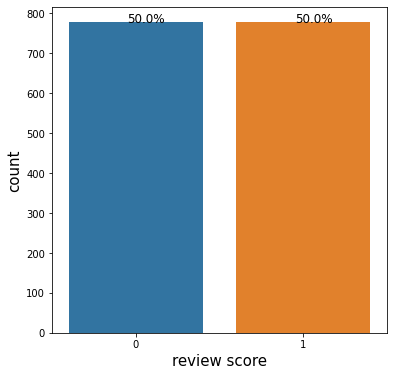

In [31]:
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

plt.figure(figsize=(6,6))
ax= sns.countplot(y_over)
plt.xlabel('review score', size=15);
plt.ylabel('count', size=15);
without_hue(ax, y_over)

## [3.3].  Split the data to train, cv, test

**Test, Train, split for imbalanced data**

In [32]:
y_label= new_df['Score']
X_label = new_df['preprocessed_reviews']
'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.33, stratify=y_label)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
'''

'\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.33, stratify=y_label)\nX_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)\n'

**Test, Train, split for the balanced data**

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.33, stratify=y_over)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

#To convert ndarray to series, which will be passed as input to featurizer
#the X_train returned in the previous step is a ndarray, we convert into pandas series
X_train = pd.Series(X_train.flatten())
y_train = pd.Series(y_train.flatten())
X_cv = pd.Series(X_cv.flatten())
y_cv = pd.Series(y_cv.flatten())
X_test = pd.Series(X_test.flatten())
y_test = pd.Series(y_test.flatten())

# [4] Featurization

## [4.1] Using DistilBertTokenizer

In [34]:
#https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
''' Not used in this project
import tensorflow as tf
train_tensor = tf.data.Dataset.from_tensor_slices((X_train['preprocessed_reviews'].values, y_train.values))
cv_tensor = tf.data.Dataset.from_tensor_slices((X_cv['preprocessed_reviews'].values, y_cv.values))
test_tensor = tf.data.Dataset.from_tensor_slices((X_test['preprocessed_reviews'].values, y_test.values))

for feat, targ in train_tensor.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))
  '''

" Not used in this project\nimport tensorflow as tf\ntrain_tensor = tf.data.Dataset.from_tensor_slices((X_train['preprocessed_reviews'].values, y_train.values))\ncv_tensor = tf.data.Dataset.from_tensor_slices((X_cv['preprocessed_reviews'].values, y_cv.values))\ntest_tensor = tf.data.Dataset.from_tensor_slices((X_test['preprocessed_reviews'].values, y_test.values))\n\nfor feat, targ in train_tensor.take(5):\n  print ('Features: {}, Target: {}'.format(feat, targ))\n  "

###[4.1.1] BERT Tokenizer

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel, DistilBertConfig
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

# To Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
bert_tokenizer =  DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



In [36]:
#We try to tokenize the 1st review text, to check how it works
text=X_train
labels=y_train
print(len(text),len(labels))

bert_tokenizer.tokenize(text[0])

698 698


['admit',
 ',',
 'sucker',
 'large',
 'quantity',
 ',',
 'oz',
 ',',
 'shopping',
 'hot',
 'sauce',
 '##s',
 '.',
 '.',
 '.',
 'but',
 'seeing',
 'size',
 'bottle',
 ',',
 'reminds',
 'wing',
 '-',
 'sauce',
 'bottle',
 'sizes',
 '.',
 'plastic',
 'bottle',
 '.',
 'convenient',
 'sq',
 '##ui',
 '##rt',
 'top',
 '.',
 'overall',
 ',',
 'hot',
 'ta',
 '##sty',
 ',',
 'ja',
 '##la',
 '##pen',
 '##os',
 '.',
 'seen',
 'ingredients',
 'list',
 'bought',
 'it',
 ':',
 'ja',
 '##la',
 '##pen',
 '##os',
 '##water',
 '##vine',
 '##gar',
 '##bro',
 '##wn',
 'sugar',
 '##lim',
 '##e',
 'juice',
 '##fish',
 'sauce',
 '##ci',
 '##lan',
 '##tro',
 '##hab',
 '##ane',
 '##ro',
 '##gar',
 '##lic',
 '##sp',
 '##ice',
 'blend',
 '##sal',
 '##tp',
 '##ota',
 '##ssi',
 '##um',
 'so',
 '##rba',
 '##te',
 '##xa',
 '##nt',
 '##han',
 'gum']

### [4.1.2] Encode/ decode a text using Bert Tokenizer

In [37]:
bert_inp=bert_tokenizer.encode_plus(text[0],add_special_tokens = True,max_length =64,pad_to_max_length = True,truncation=True)
print(bert_inp)
print("****Attention mask below**")
print(bert_inp['attention_mask'])

bert_tokenizer.decode(bert_inp['input_ids'])


{'input_ids': [101, 6449, 1010, 26476, 2312, 11712, 1010, 11472, 1010, 6023, 2980, 12901, 2015, 1012, 1012, 1012, 2021, 3773, 2946, 5835, 1010, 15537, 3358, 1011, 12901, 5835, 10826, 1012, 6081, 5835, 1012, 14057, 5490, 10179, 5339, 2327, 1012, 3452, 1010, 2980, 11937, 21756, 1010, 14855, 2721, 11837, 2891, 1012, 2464, 12760, 2862, 4149, 2009, 1024, 14855, 2721, 11837, 2891, 5880, 20534, 6843, 12618, 7962, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
****Attention mask below**
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


'[CLS] admit, sucker large quantity, oz, shopping hot sauces... but seeing size bottle, reminds wing - sauce bottle sizes. plastic bottle. convenient squirt top. overall, hot tasty, jalapenos. seen ingredients list bought it : jalapenoswatervinegarbrown [SEP]'

### [4.1.3] Prepare the tensor for DBert Train, test and cv

In [38]:
#Preparing the input for BERT , we pass text and ylabel as input 
max_len=64
def prepare_inp(input_text, y_label):
  input_ids=[]
  attention_masks=[]
  bert_tokenizer =  DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
  for ip in input_text:
      dbert_inps=bert_tokenizer.encode_plus(ip,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
      input_ids.append(dbert_inps['input_ids'])
      attention_masks.append(dbert_inps['attention_mask'])

  input_ids=np.asarray(input_ids)
  attention_masks=np.array(attention_masks)
  labels=np.array(y_label)

  return input_ids,attention_masks,labels


Get the input_ids, Attention mask, labels for train, cv and test and store in pickle file to build the model

In [39]:
train_inp,train_mask,train_label=prepare_inp(X_train,y_train)
cv_inp,cv_mask,cv_label=prepare_inp(X_cv,y_cv)
test_inp,test_mask,test_label=prepare_inp(X_test,y_test)

print('Train inp shape {} , Train label shape {} , Train attention mask shape {} \n'.format(train_inp.shape,train_label.shape,train_mask.shape))
print('cv inp shape {} , cvlabel shape {} , cv attention mask shape {} \n'.format(cv_inp.shape,cv_label.shape,cv_mask.shape))
print('Test inp shape {} , Test label shape {} , Test attention mask shape {} \n'.format(test_inp.shape,test_label.shape,test_mask.shape))

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropo

Train inp shape (698, 64) , Train label shape (698,) , Train attention mask shape (698, 64) 

cv inp shape (344, 64) , cvlabel shape (344,) , cv attention mask shape (344, 64) 

Test inp shape (514, 64) , Test label shape (514,) , Test attention mask shape (514, 64) 



## Sentence Transformer

In [98]:
#https://www.sbert.net/index.html
from sentence_transformers import SentenceTransformer,util
sent_trans_model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.']
    
embeddings = sent_trans_model.encode(sentences)
embeddings

loading configuration file /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config.json
Model config BertConfig {
  "_name_or_path": "/root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin
All model checkpoint weights were used when i

array([[-1.37173468e-02, -4.28515449e-02, -1.56285837e-02,
         1.40537750e-02,  3.95538211e-02,  1.21796295e-01,
         2.94333491e-02, -3.17524038e-02,  3.54959629e-02,
        -7.93140009e-02,  1.75878983e-02, -4.04369719e-02,
         4.97259349e-02,  2.54912004e-02, -7.18701035e-02,
         8.14968795e-02,  1.47068314e-03,  4.79626879e-02,
        -4.50336263e-02, -9.92174745e-02, -2.81769708e-02,
         6.45046160e-02,  4.44670804e-02, -4.76217009e-02,
        -3.52952406e-02,  4.38671410e-02, -5.28566092e-02,
         4.33077395e-04,  1.01921506e-01,  1.64072327e-02,
         3.26996520e-02, -3.45986784e-02,  1.21339010e-02,
         7.94870853e-02,  4.58346074e-03,  1.57778412e-02,
        -9.68204252e-03,  2.87625883e-02, -5.05805947e-02,
        -1.55793512e-02, -2.87906155e-02, -9.62282624e-03,
         3.15556899e-02,  2.27348879e-02,  8.71449113e-02,
        -3.85027081e-02, -8.84718448e-02, -8.75496585e-03,
        -2.12343428e-02,  2.08923165e-02, -9.02077779e-0

In [41]:
#https://stackoverflow.com/questions/68334844/how-to-save-sentence-bert-output-vectors-to-a-file
def get_transformer_embedding(corpus_sentences, embedding_cache_path):
  if not os.path.exists(embedding_cache_path):
    # read your corpus etc
    print("Encoding the corpus. This might take a while")
    corpus_embeddings = sent_trans_model.encode(corpus_sentences, show_progress_bar=True, convert_to_numpy=True)
    corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

    print("Storing file on disc")
    with open(embedding_cache_path, "wb") as fOut:
        pickle.dump({'sentences': corpus_sentences, 'embeddings': corpus_embeddings}, fOut)

  else:
      print("Loading pre-computed embeddings from disc")
      with open(embedding_cache_path, "rb") as fIn:
          cache_data = pickle.load(fIn)
          corpus_sentences = cache_data['sentences']
          corpus_embeddings = cache_data['embeddings']
  return corpus_embeddings

x_final_tf_idf =  get_transformer_embedding(X_train, "//content/drive/My Drive/AI_assignment/amazon_food_review/train-embeddings.pkl")
cv_final_tf_idf = get_transformer_embedding(X_cv, "//content/drive/My Drive/AI_assignment/amazon_food_review/cv-embeddings.pkl")
final_tf_idf = get_transformer_embedding(X_test,  "//content/drive/My Drive/AI_assignment/amazon_food_review/test-embeddings.pkl")

Loading pre-computed embeddings from disc
Loading pre-computed embeddings from disc
Loading pre-computed embeddings from disc


# [5] Assignment 3: BERT/ KNN For Sentence/Review Analysis 

<ol>
  <li><strong>Apply DBERT classification on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using DBERT</li>
        </ul>
    </li>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
        </ul>
    </li>
    <br>
    <li><strong>For KNN use the hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>summarize the results at the end of the notebook
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [114]:
#Roc curve
#https://www.kaggle.com/surentharbe/credit-card-fraud-detection-using-svm-100-auprc
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ["Vectorizer", "Model", "Hyper parameter1", "Hyper parameter2", "AUC", "F1 Score"]

## [5.1] DBERT Model

In [43]:
#Unique class labels
max_len=64  #Max sentence length
num_classes = len(y_train.unique())
print(num_classes)

#Defining the loss function we would like to use
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)


def create_bert_model():
    dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Define input layers
    input_ids_layer  = Input(shape = (max_len,),  name='input_ids',  dtype='int64')
    input_attention_layer = Input(shape = (max_len,),  name='input_attention', dtype='int64')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = dbert_model(input_ids_layer, attention_mask=input_attention_layer )[0]
    
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data
    cls_token = last_hidden_state[:, 0, :]

    dense = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01))(cls_token)
    dropout1= Dropout(0.3)(dense)

    dense = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dropout1)
    dropout2= Dropout(0.3)(dense)
    
    # Define a single node that makes up the output layer (for binary classification)
    pred = Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(dropout2)
    
    model = tf.keras.Model(inputs=[input_ids_layer,input_attention_layer], outputs=pred)
    model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
    print(model.summary())
    return model

2


**Callbacks**

In [44]:
log_dir='dbert_model'

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

base_folder = "/content/drive/My Drive/AI_assignment/amazon_food_review/"
model_save_path='./dbert_model.h5'


#https://keras.io/api/callbacks/
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=base_folder  + '/seg_' +  
                                                'weights.best.hdf5',save_weights_only=True,
                                                monitor='val_loss',mode='min',save_best_only=True),
            tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)]


def display_training_loss_and_accuracy(iteration, history):
    
    title1 = 'model accuracy for iteration :' + str(iteration)
    title2 = 'model loss for iteration :' + str(iteration)
    plt.figure(figsize=(20,4))
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count,history.history['accuracy'])
    plt.plot(epoch_count,history.history['val_accuracy'])
    plt.title(title1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(epoch_count,history.history['loss'])
    plt.plot(epoch_count,history.history['val_loss'])
    plt.title(title2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

### [5.1.1] Training the BERT MODEL

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tf_model.h5
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoi

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 64)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 64, 768),                                                    
                                 hidden_states=None                                           

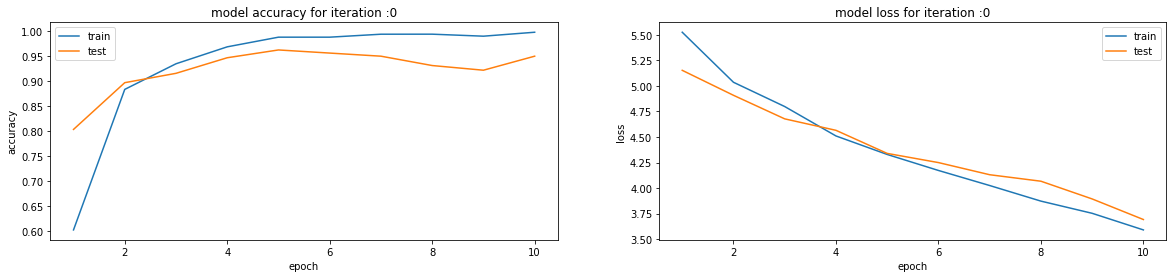

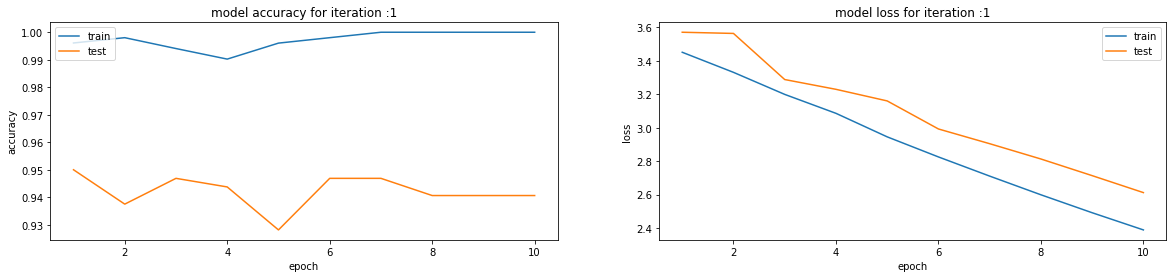

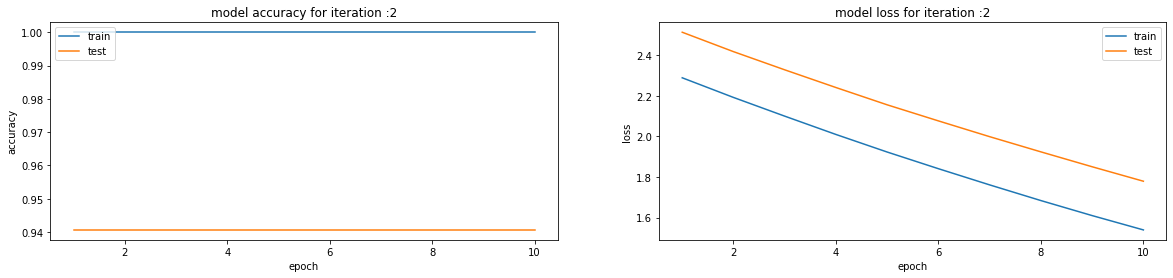

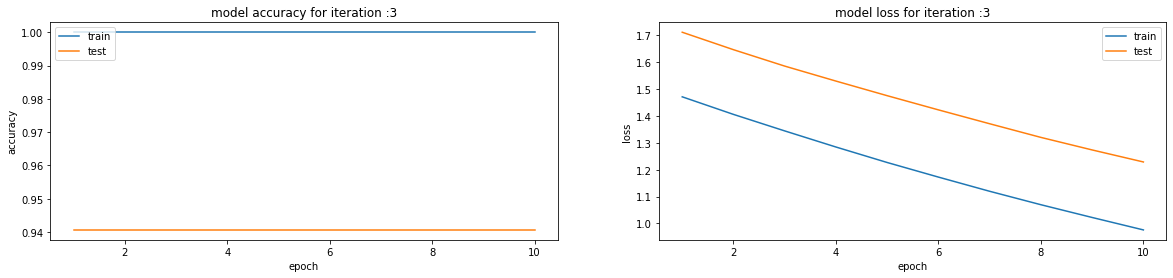

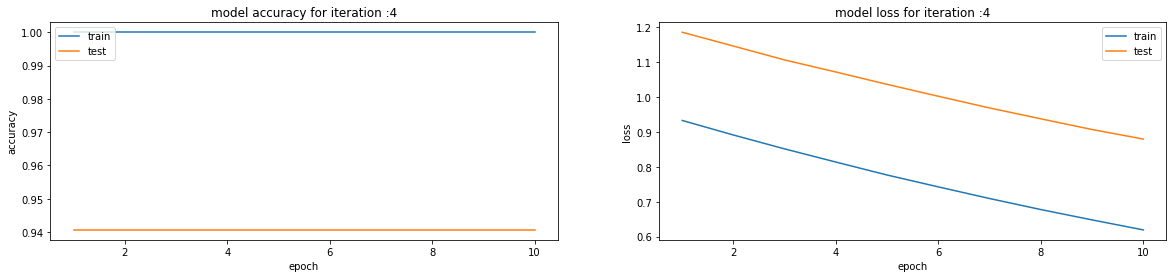

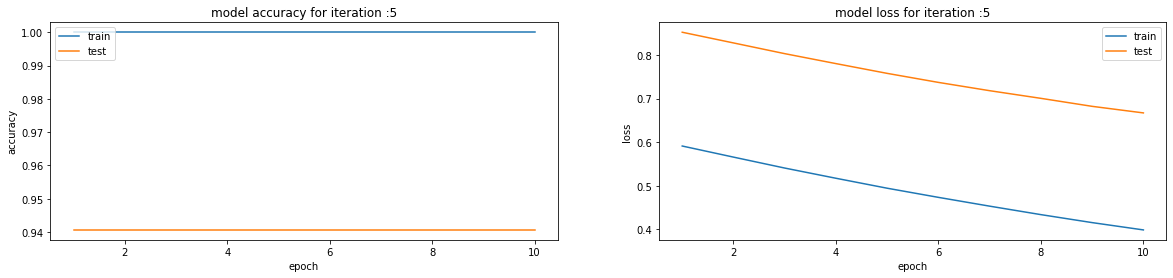

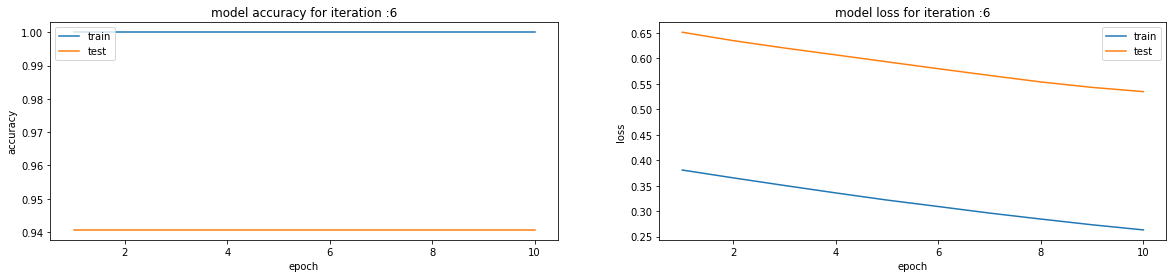

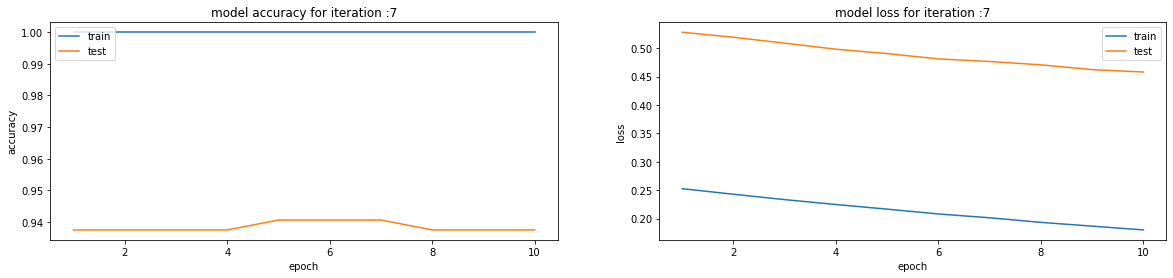

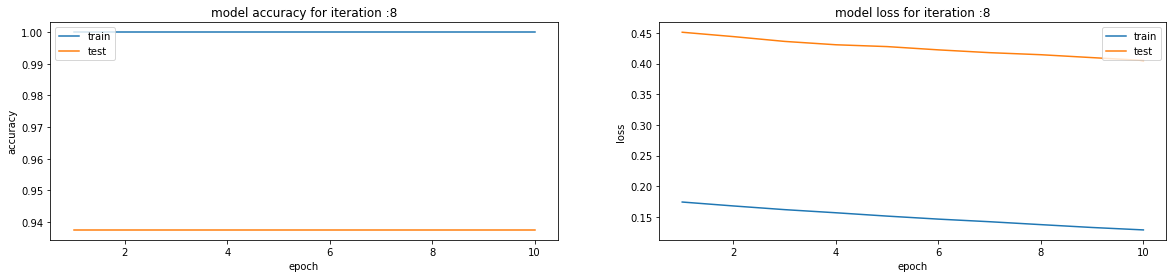

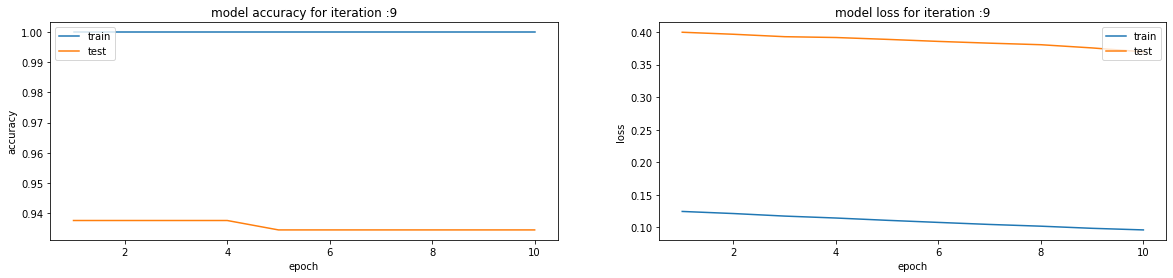

In [45]:
# Hyper parameters
#evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
epochs = 10
stepsforepoch = 16
#n_iter = 20000 # No. of training iterations
n_iter = 10 # No. of training iterations
N_way = 20 # how many persons for testing one-shot tasks
best = -1


def train_bert_model(train_inp,train_mask,train_label,cv_inp,cv_mask,cv_label ):

  model=create_bert_model()
  print("Starting training process!")
  print("-------------------------------------")
  t_start = time.time()
  history_list = []
  for i in range(n_iter):
      print("Iteration # : " , i)
      
      history = model.fit([train_inp,train_mask],train_label, 
                            batch_size=batch_size,
                            steps_per_epoch=stepsforepoch, 
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks, 
                            validation_data=([cv_inp,cv_mask],cv_label),
                            validation_steps=10, 
                            validation_freq=1)
    
      history_list.append(history)
  
  print(history_list[0].history)
  for i in  range(len(history_list)):
      history = history_list[i]
      display_training_loss_and_accuracy(i, history)
  #model=create_bert_model()
  #history=model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=3, validation_data=([cv_inp,cv_mask],cv_label),callbacks=callbacks)
 
train_bert_model(train_inp,train_mask,train_label,cv_inp,cv_mask,cv_label)


### [5.1.2]Test our BERT model on the unseen data**

In [46]:
# Load model weights with trained model weights
model=create_bert_model()
model.load_weights(os.path.join(base_folder, "seg_weights.best.hdf5"))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tf_model.h5
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activa

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 64)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 64, 768),                                                    
                                 hidden_states=None                                         

**Predict and plot F1 score for the test data**

In [68]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report

y_pred_keras = model.predict([test_inp,test_mask])
pred_labels = y_pred_keras.argmax(axis=1)

f1 = f1_score(test_label,pred_labels)
print('F1 score',f1)
print()
print('Classification Report')
print(classification_report(test_label,pred_labels,  labels=[0,1]))

17/17 [==============================] - 58s 3s/step
F1 score 0.9264413518886679

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       257
           1       0.95      0.91      0.93       257

    accuracy                           0.93       514
   macro avg       0.93      0.93      0.93       514
weighted avg       0.93      0.93      0.93       514



**Plotting confusion matrix for the test data** 

Confusion matrix
[[244  13]
 [ 24 233]]


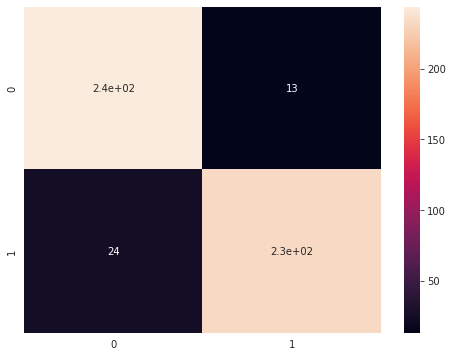

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print('Confusion matrix')
print(confusion_matrix(test_label, pred_labels))

labels = [0, 1]
cm =confusion_matrix(test_label, pred_labels)  
index = [0,1]  
columns = [0,1]  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(8,6))  
sns.heatmap(cm_df, annot=True)


**Plotting AUC for the test data**

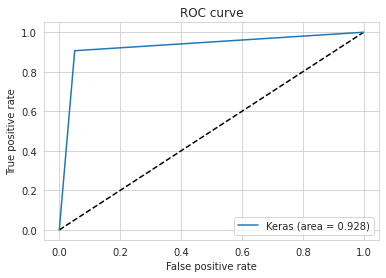

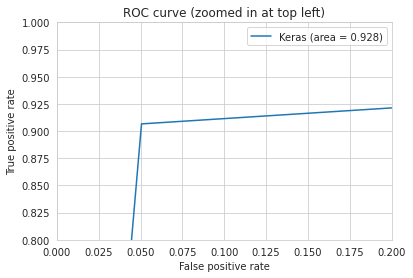

In [115]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_label, pred_labels)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

table.add_row(["Bert","Bert Encoder", " ", " ", auc_keras, f1_score(test_label,pred_labels)])

**KNN Model**

In [89]:
#creating a method for KNN which will be reused by all the algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
def Train_data_KNN(X_train,y_train, X_cv, y_cv,algorithm):
    train_auc = []
    cv_auc = []
    K = [1, 5, 10, 15, 21, 31, 41, 51, 61,71, 81, 91]
    for i in K:
        neigh = KNeighborsClassifier(n_neighbors=i, algorithm=algorithm)
        neigh.fit(X_train, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  neigh.predict_proba(X_train)[:,1]
        y_cv_pred =  neigh.predict_proba(X_cv)[:,1]

        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

    sns.set_style("whitegrid");
    plt.plot(K, train_auc, label='Train AUC')
    plt.scatter(K, train_auc, label='Train AUC')
    plt.plot(K, cv_auc, label='CV AUC')
    plt.scatter(K, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

In [101]:
def Test_Data_KNN(X_train, y_train,X_test,y_test, algorithm,best_k, vectorizer):
    neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm=algorithm)
    neigh.fit(X_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

    sns.set_style("whitegrid");
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

    print("="*100)

    from sklearn.metrics import confusion_matrix
    print("Train confusion matrix")
    print(confusion_matrix(y_train, neigh.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, neigh.predict(X_test)))

    #Adding the results to prettytable
    auc_value = str(auc(test_fpr,test_tpr))

    table.add_row(["Sentence_transformer","KNN", best_k," ", auc_value, f1_score(y_test,neigh.predict(X_test))])

## [5.3] Applying KNN kd-tree

### [5.3.2] Applying KNN kd-tree on Sentence Transformer,<font color='red'> SET 2</font>

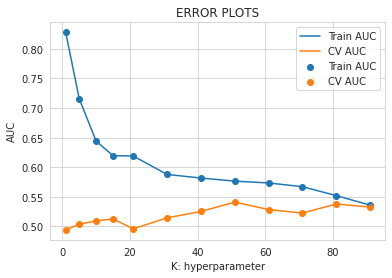

In [90]:
# Please write all the code with proper documentation
Train_data_KNN(x_final_tf_idf,y_train,cv_final_tf_idf,y_cv,'kd_tree')

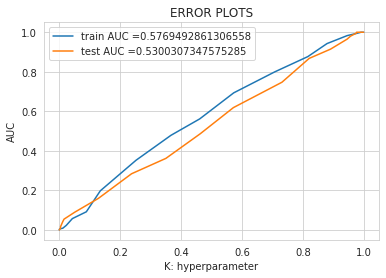

Train confusion matrix
[[221 128]
 [182 167]]
Test confusion matrix
[[167  90]
 [164  93]]


In [116]:
Test_Data_KNN(x_final_tf_idf, y_train, final_tf_idf, y_test,'kd_tree', best_k=50,vectorizer="sentence Transformer")

## [5.4] Applying Random Forest

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)


def Train_data(X_tr,y_train,vectorizer):
  max_depth= [2,3,4,5,6,7,8,9,10]
  n_estimators = [10, 50, 100, 140, 180, 220, 260]
  tuned_parameters = [{'n_estimators': n_estimators, 'max_depth': max_depth }]
  clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),tuned_parameters, cv=3, scoring='roc_auc', return_train_score=True)
  clf.fit(X_tr, y_train)
  best_parameters = clf.best_params_

  print("The best parameters for using this model is", best_parameters)
  print("Best Estimator ",clf.best_estimator_)
  
  K =clf.cv_results_['param_max_depth']
  train_auc = clf.cv_results_['mean_train_score']
  train_auc_std = clf.cv_results_['std_train_score']
  cv_auc = clf.cv_results_['mean_test_score']
  cv_auc_std= clf.cv_results_['std_test_score']
  print("="*100)
  print("3D visualisation")
  
  # https://plot.ly/python/3d-axes/
  trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name ='Train')
  trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=cv_auc, name = 'Cross_validation')
  data = [trace1, trace2]
  
  '''
  enable_plotly_in_cell()
  layout = go.Layout(scene = dict(
  xaxis = dict(title='n_estimators'),
  yaxis = dict(title='max_depth'),
  zaxis = dict(title='AUC'),))
  fig = go.Figure(data=data, layout=layout)
  offline.iplot(fig, filename='3d-scatter-colorscale')
  print("="*100)
  '''

  print("HeatMap of Train and CV")
  #Heatmap https://www.kaggle.com/arindambanerjee/grid-search-simplified
  max_depth_list = list(clf.cv_results_['param_max_depth'].data)
  n_estimators_list = list(clf.cv_results_['param_n_estimators'].data)
  sns.set_style("whitegrid")
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_train_score']})
  data = data.pivot(index='n_estimators', columns='Max Depth', values='AUC')
  sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Training␣data')
  plt.subplot(1,2,2)
  data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_test_score']})

  data = data.pivot(index='n_estimators', columns='Max Depth', values='AUC')
  sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for CV data')
  plt.show()
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_max_depth'])

Output hidden; open in https://colab.research.google.com to view.

In [107]:
#Round off the predicted values to fix value error
#https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target
from mlxtend.plotting import plot_confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from graphviz import Source
from sklearn.metrics import confusion_matrix

def draw_train_confusion_matrix(CM):
  fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
  show_absolute=True,
  show_normed=True)
  plt.title("Train Confusion Matrix ")
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()

def draw_test_confusion_matrix(CM):
  fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True, show_absolute=True, show_normed=True)
  plt.title("Test Confusion Matrix ")
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()

def find_best_threshold(threshould, fpr, tpr):
  t = threshould[np.argmax(tpr*(1-fpr))]
  # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very␣high
  print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "forthreshold", np.round(t,3))
  return t

def predict_with_best_t(proba, threshould):
  predictions = []
  for i in proba:
    if i>=threshould:
      predictions.append(1)
    else:
      predictions.append(0)
  return predictions

def Test_Data(X_train, y_train,X_test,y_test,max_depth,n_estimators,vectorizer):
  clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,class_weight='balanced')
  clf.fit(X_train, y_train)

  # roc_auc_score(y_true, y_score) the 2nd parameter should be probability␣stimates of the positive class
  # not the predicted outputs
  clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
  clf_calibrated.fit(X_train, y_train)
  y_train_pred = clf_calibrated.predict_proba(X_train)[:,1]
  y_test_pred =clf_calibrated.predict_proba(X_test)[:,1]
  train_fpr, train_tpr, thresholds = roc_curve(y_train,y_train_pred)
  test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred)
  sns.set_style("whitegrid");
  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr,train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr,test_tpr)))
  plt.legend()
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.title("ROC Curve using %s "%vectorizer)
  plt.show()
  
  print("="*100)

  print("Train confusion matrix")
  y_train_pred_val = []
  for item in y_train_pred:
    y_train_pred_val.append(int(round(item)))
    y_test_pred_val = []
  for item in y_test_pred:
    round_item =int(round(item))
    y_test_pred_val.append(round_item)

  print("="*100)

  best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
  print("Train confusion matrix")
  predicted_train=predict_with_best_t(y_train_pred_val, best_t)
  cm_train = confusion_matrix(y_train, predicted_train)
  print(cm_train)
  draw_train_confusion_matrix(cm_train)
  print("Test confusion matrix")
  predicted_test=predict_with_best_t(y_test_pred_val, best_t)
  cm_test = confusion_matrix(y_test, predicted_test)
  print(cm_test)
  draw_test_confusion_matrix(cm_test)

  #Adding the results to prettytable
  auc_value = str(auc(test_fpr,test_tpr))
  table.add_row(["Sentence_transformer","Random Forest", n_estimators, max_depth, auc_value, f1_score(y_test,predicted_test)])

The best parameters for using this model is {'max_depth': 3, 'n_estimators': 10}
Best Estimator  RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=10)
3D visualisation
HeatMap of Train and CV


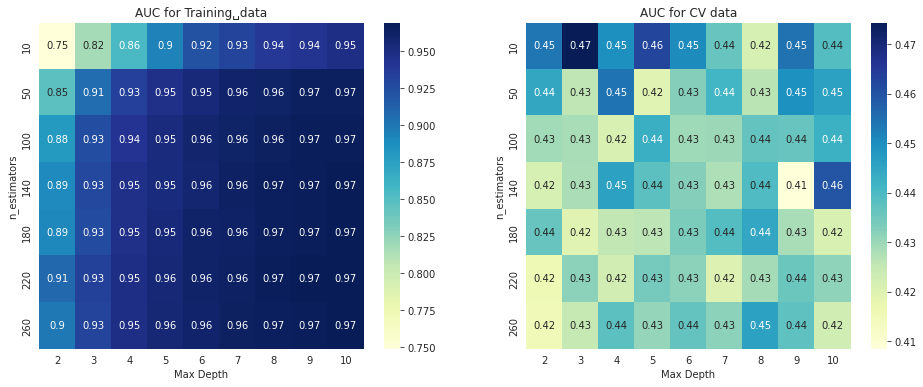

In [111]:
Train_data(x_final_tf_idf,y_train,vectorizer="sentence Transformer")

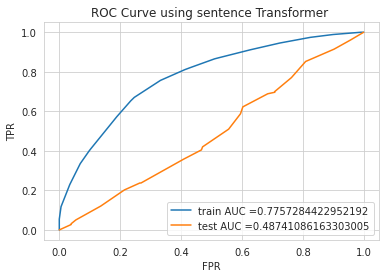

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.5052667876290015 forthreshold 0.636
Train confusion matrix
[[233 116]
 [ 85 264]]


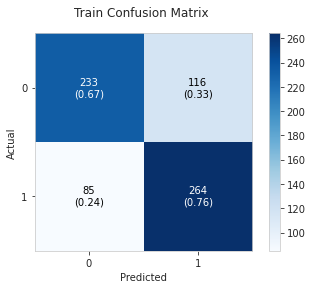

Test confusion matrix
[[114 143]
 [126 131]]


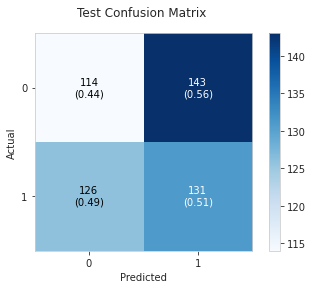

In [117]:
Test_Data(x_final_tf_idf,y_train, final_tf_idf,y_test, max_depth=3,n_estimators=10,vectorizer="sentence Transformer")

# [6] Conclusions

In [118]:
print(table)

+----------------------+---------------+------------------+------------------+---------------------+---------------------+
|      Vectorizer      |     Model     | Hyper parameter1 | Hyper parameter2 |         AUC         |       F1 Score      |
+----------------------+---------------+------------------+------------------+---------------------+---------------------+
|         Bert         |  Bert Encoder |                  |                  |  0.9280155642023346 |  0.9264413518886679 |
| Sentence_transformer |      KNN      |        50        |                  |  0.5300307347575285 | 0.42272727272727273 |
| Sentence_transformer | Random Forest |        10        |        3         | 0.48741086163303005 |  0.4934086629001883 |
+----------------------+---------------+------------------+------------------+---------------------+---------------------+


1) We compared the performance of DistilBert and KNN over the Amazon fine food review dataset   
2) We trained our models and tested the performance of our model over unseen test data and plotted the confusion matrix   
3) From the confusion matrix its clear that DistilBert is able to predict with an accuracy score of 95%.   
4) we can further tune the model to achieve a better accuracy.